# Demo of fkptjax Calculations

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import fkptjax.snapshot
import fkptjax.util
import fkptjax.plot

### Prepare Inputs

Load the default inputs included with the package:

In [4]:
snap = fkptjax.snapshot.load_snapshot()

A calculation requires the following physical and numerical parameters to be specified:

In [5]:
snap.print_params()

Input Parameters

Cosmology:
  Growth rate at k→0 (f0)                : 0.749238

Output k-grid (for computed KFunctions):
  Minimum k (kmin)                       : 0.001000 h/Mpc
  Maximum k (kmax)                       : 0.500000 h/Mpc
  Number of k points (Nk)                : 120

Numerical Integration:
  Quadrature steps for k-integration     : 300
  Gauss-Legendre points for Q-functions  : 10
  Gauss-Legendre points for R-functions  : 10

SPT Kernel Constants (LCDM):
  Kernel constant A (KA_LCDM)            : 1.000000
  Kernel constant Ap (KAp_LCDM)          : 0.000000
  Kernel constant CFD3 (KR1_LCDM)        : 1.000000
  Kernel constant CFD3' (KR1p_LCDM)      : 1.000000

Variance and Damping:
  Velocity dispersion σ²_v (sigma2v)     : 23.309617 (Mpc/h)²


You must also specify a linear matter power spectrum and its corresponding no-wiggles power. Plot these arrays from the snapshot:

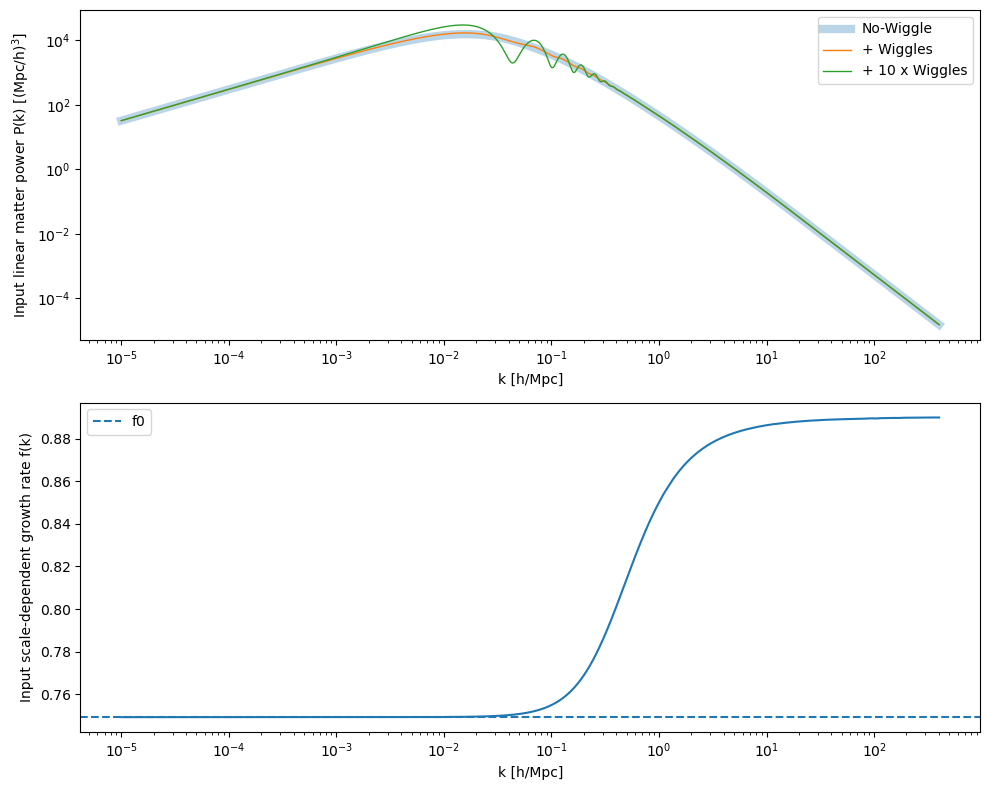

In [6]:
fkptjax.plot.plot_input_arrays(snap.arrays.k_in, snap.arrays.Pk_in, snap.arrays.Pk_nw_in, snap.arrays.f_in, snap.params.f0);

Prepare the initialization data required by the calculators below:

In [7]:
init_data = fkptjax.util.setup_kfunctions(
    k_in=snap.arrays.k_in,
    kmin=snap.params.kmin, kmax=snap.params.kmax, Nk=snap.params.Nk,
    nquadSteps=snap.params.nquadSteps, NQ=snap.params.NQ, NR=snap.params.NR)

### Select and Prepare Calculator

Choose between a pure-numpy and jax-accelerated implementation. The jax acceleration will use a GPU when available, but also speeds up a CPU-only calculation.

In [8]:
#from fkptjax.calculate_numpy import NumpyCalculator as Calculator
from fkptjax.calculate_jax import JaxCalculator as Calculator

One-time initialization of the calculator to establish the numerical parameters and k grids to use. This is relatively slow (few seconds) for the jax implementation. 

In [9]:
calculator = Calculator()
calculator.initialize(init_data)

### Evaluate K Functions

Evaluate k functions for each new input cosmology. There is no need to re-initialize when only the inputs to `evaluate()` are changing. The first call is relatively slow for the jax implementation due to JIT compilation.

In [10]:
# Bundle evaluate() args so we can re-use them for timing below
eval_args = dict(
    # cosmology
    Pk_in=snap.arrays.Pk_in, Pk_nw_in=snap.arrays.Pk_nw_in, fk_in=snap.arrays.f_in,
    # kernel constants
    A=snap.params.KA_LCDM, ApOverf0=snap.params.KAp_LCDM/snap.params.f0,
    CFD3=snap.params.KR1_LCDM, CFD3p=snap.params.KR1p_LCDM,
    # other parameters
    sigma2v=snap.params.sigma2v, f0=snap.params.f0)

In [11]:
kfuncs = calculator.evaluate(**eval_args)

The returned functions of $k$ are bundled into a dataclass (`fkptjax.types.KFunctionsOut`) documented [here](https://github.com/cosmodesi/fkptjax/blob/main/KFUNCTIONS.md).

Validate the calculated results against k functions calculated by the C code and stored in the snapshot:

In [12]:
fkptjax.util.validate_kfunctions(kfuncs, snap)

True

Time the evaluation code (not including the initial JIT overhead):

In [13]:
%timeit calculator.evaluate(**eval_args)

23.9 ms ± 289 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Plot K Functions

Plot the calculated one-loop pieces for density/velocity combinations (P22, P13):

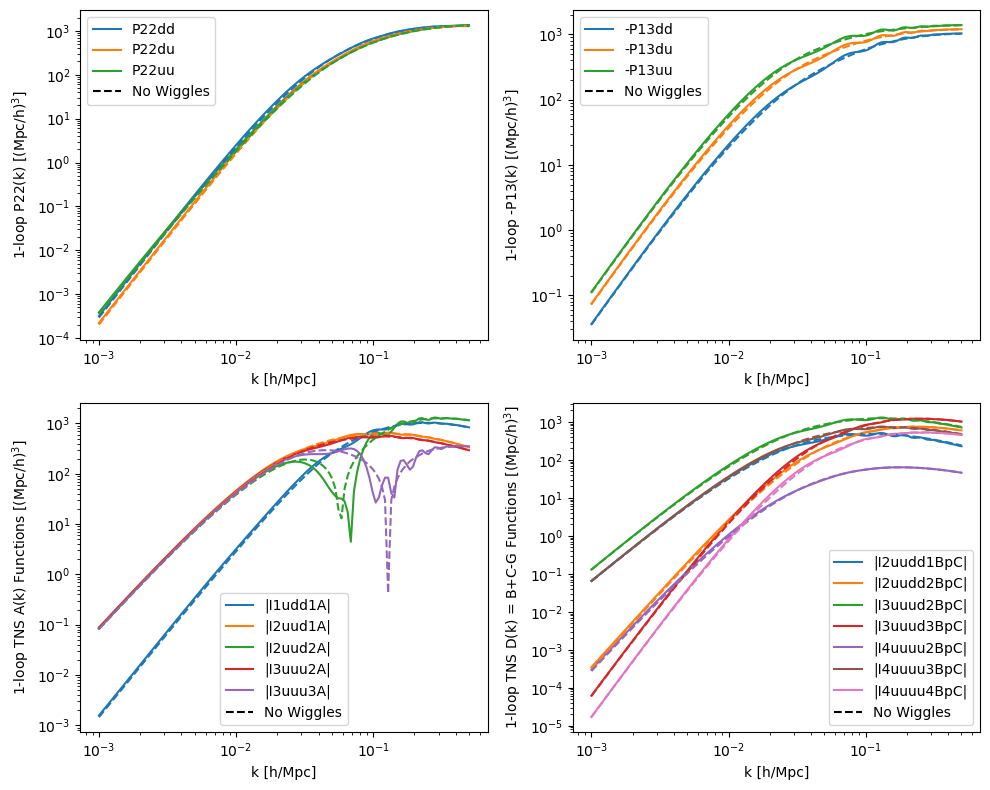

In [14]:
fkptjax.plot.plot_one_loop(
    init_data.logk_grid,
    kfuncs.P22dd, kfuncs.P22du, kfuncs.P22uu,
    kfuncs.P13dd, kfuncs.P13du, kfuncs.P13uu,
    kfuncs.I1udd1A, kfuncs.I2uud1A, kfuncs.I2uud2A,
    kfuncs.I3uuu2A, kfuncs.I3uuu3A,
    kfuncs.I2uudd1BpC, kfuncs.I2uudd2BpC,
    kfuncs.I3uuud2BpC, kfuncs.I3uuud3BpC,
    kfuncs.I4uuuu2BpC, kfuncs.I4uuuu3BpC, kfuncs.I4uuuu4BpC);

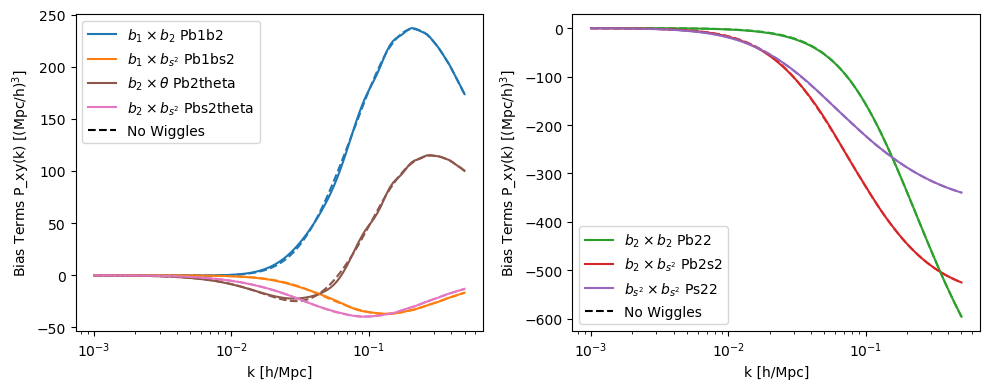

In [15]:
fkptjax.plot.plot_bias_terms(
    init_data.logk_grid,
    kfuncs.Pb1b2, kfuncs.Pb1bs2, kfuncs.Pb22,
    kfuncs.Pb2s2, kfuncs.Ps22, kfuncs.Pb2theta, kfuncs.Pbs2theta);